
# Load the houseprices data from Thinkful's database. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.

In [745]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from  sklearn.linear_model import LassoCV
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')



In [746]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [747]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices', con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [748]:
#investigate data
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [749]:
houseprices_df.shape #here we can see we have 1460 rows and 81 columns

(1460, 81)

In [750]:
#let's look at object types
houseprices_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [751]:
houseprices_df1= houseprices_df # make a copy. It is good practice just in case we need to see original data

In [752]:
houseprices_df1.isnull().sum()*100/len(houseprices_df1).ascending

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
                   ...    
bedroomabvgr      0.000000
kitchenabvgr      0.000000
kitchenqual       0.000000
totrmsabvgrd      0.000000
functional        0.000000
fireplaces        0.000000
f

In [753]:
num_cols= houseprices_df1.select_dtypes(include=['int', 'float'])

In [754]:
num_cols.isnull().sum().sort_values(ascending=False).head(5)

lotfrontage     259
garageyrblt      81
masvnrarea        8
bsmtfinsf1        0
lowqualfinsf      0
dtype: int64

In [755]:
#replacing missing values
houseprices_df1.lotfrontage.interpolate(inplace=True)
houseprices_df1.masvnrarea.interpolate(inplace=True)
garage_yr_mean = houseprices_df1['garageyrblt'].mean()
garage_yr_mean
houseprices_df['garageyrblt'].fillna(garage_yr_mean,inplace=True)


In [756]:
c=num_cols.corr().abs()
num_corr=num_cols.iloc[:,1:].corr().loc[:,"saleprice"].abs()
num_corr.sort_values(ascending= False).head(6)

saleprice      1.000000
overallqual    0.790982
grlivarea      0.708624
garagecars     0.640409
garagearea     0.623431
totalbsmtsf    0.613581
Name: saleprice, dtype: float64

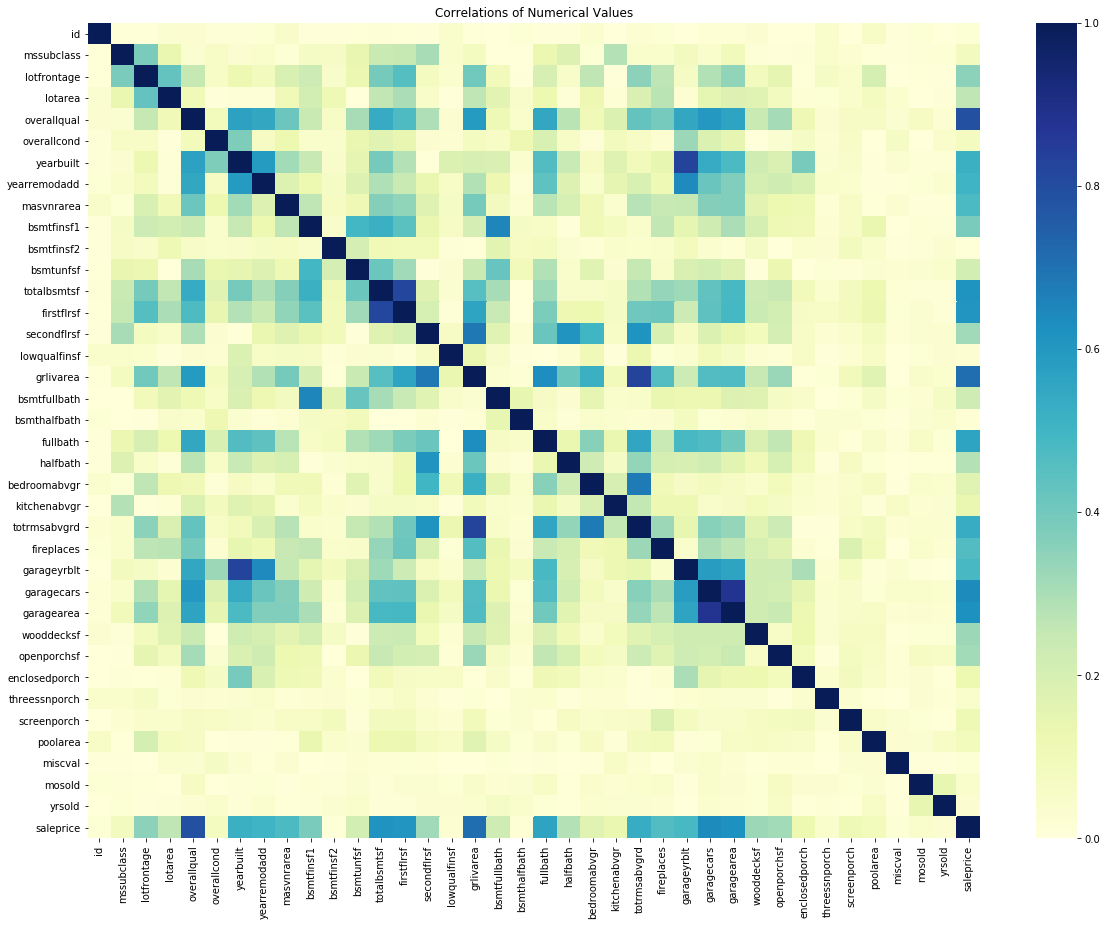

In [757]:
plt.figure(figsize=(20,15))
sns.heatmap(c, cmap="YlGnBu")
plt.title('Correlations of Numerical Values')
plt.show()

### From here we can see that our first five features that are correlated with saleprice are overallqual, grlivarea, garagecars, garagearea and totalbsmtsf. 

In [758]:
cat_cols= houseprices_df.select_dtypes(exclude=['int', 'float'])
cat_cols.isnull().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
garagecond        81
garagequal        81
garagefinish      81
garagetype        81
bsmtfintype2      38
bsmtexposure      38
bsmtfintype1      37
bsmtqual          37
bsmtcond          37
masvnrtype         8
electrical         1
condition2         0
condition1         0
neighborhood       0
landslope          0
dtype: int64

### The features are not really missing in some values after inspection. It appears that they are just non-existant or the property does not have it. We can replace it with 'none'. However, there are only 14 categorical variables that  have missing data, and other variables are fine. So for now, we will just use variables with nothing missing.

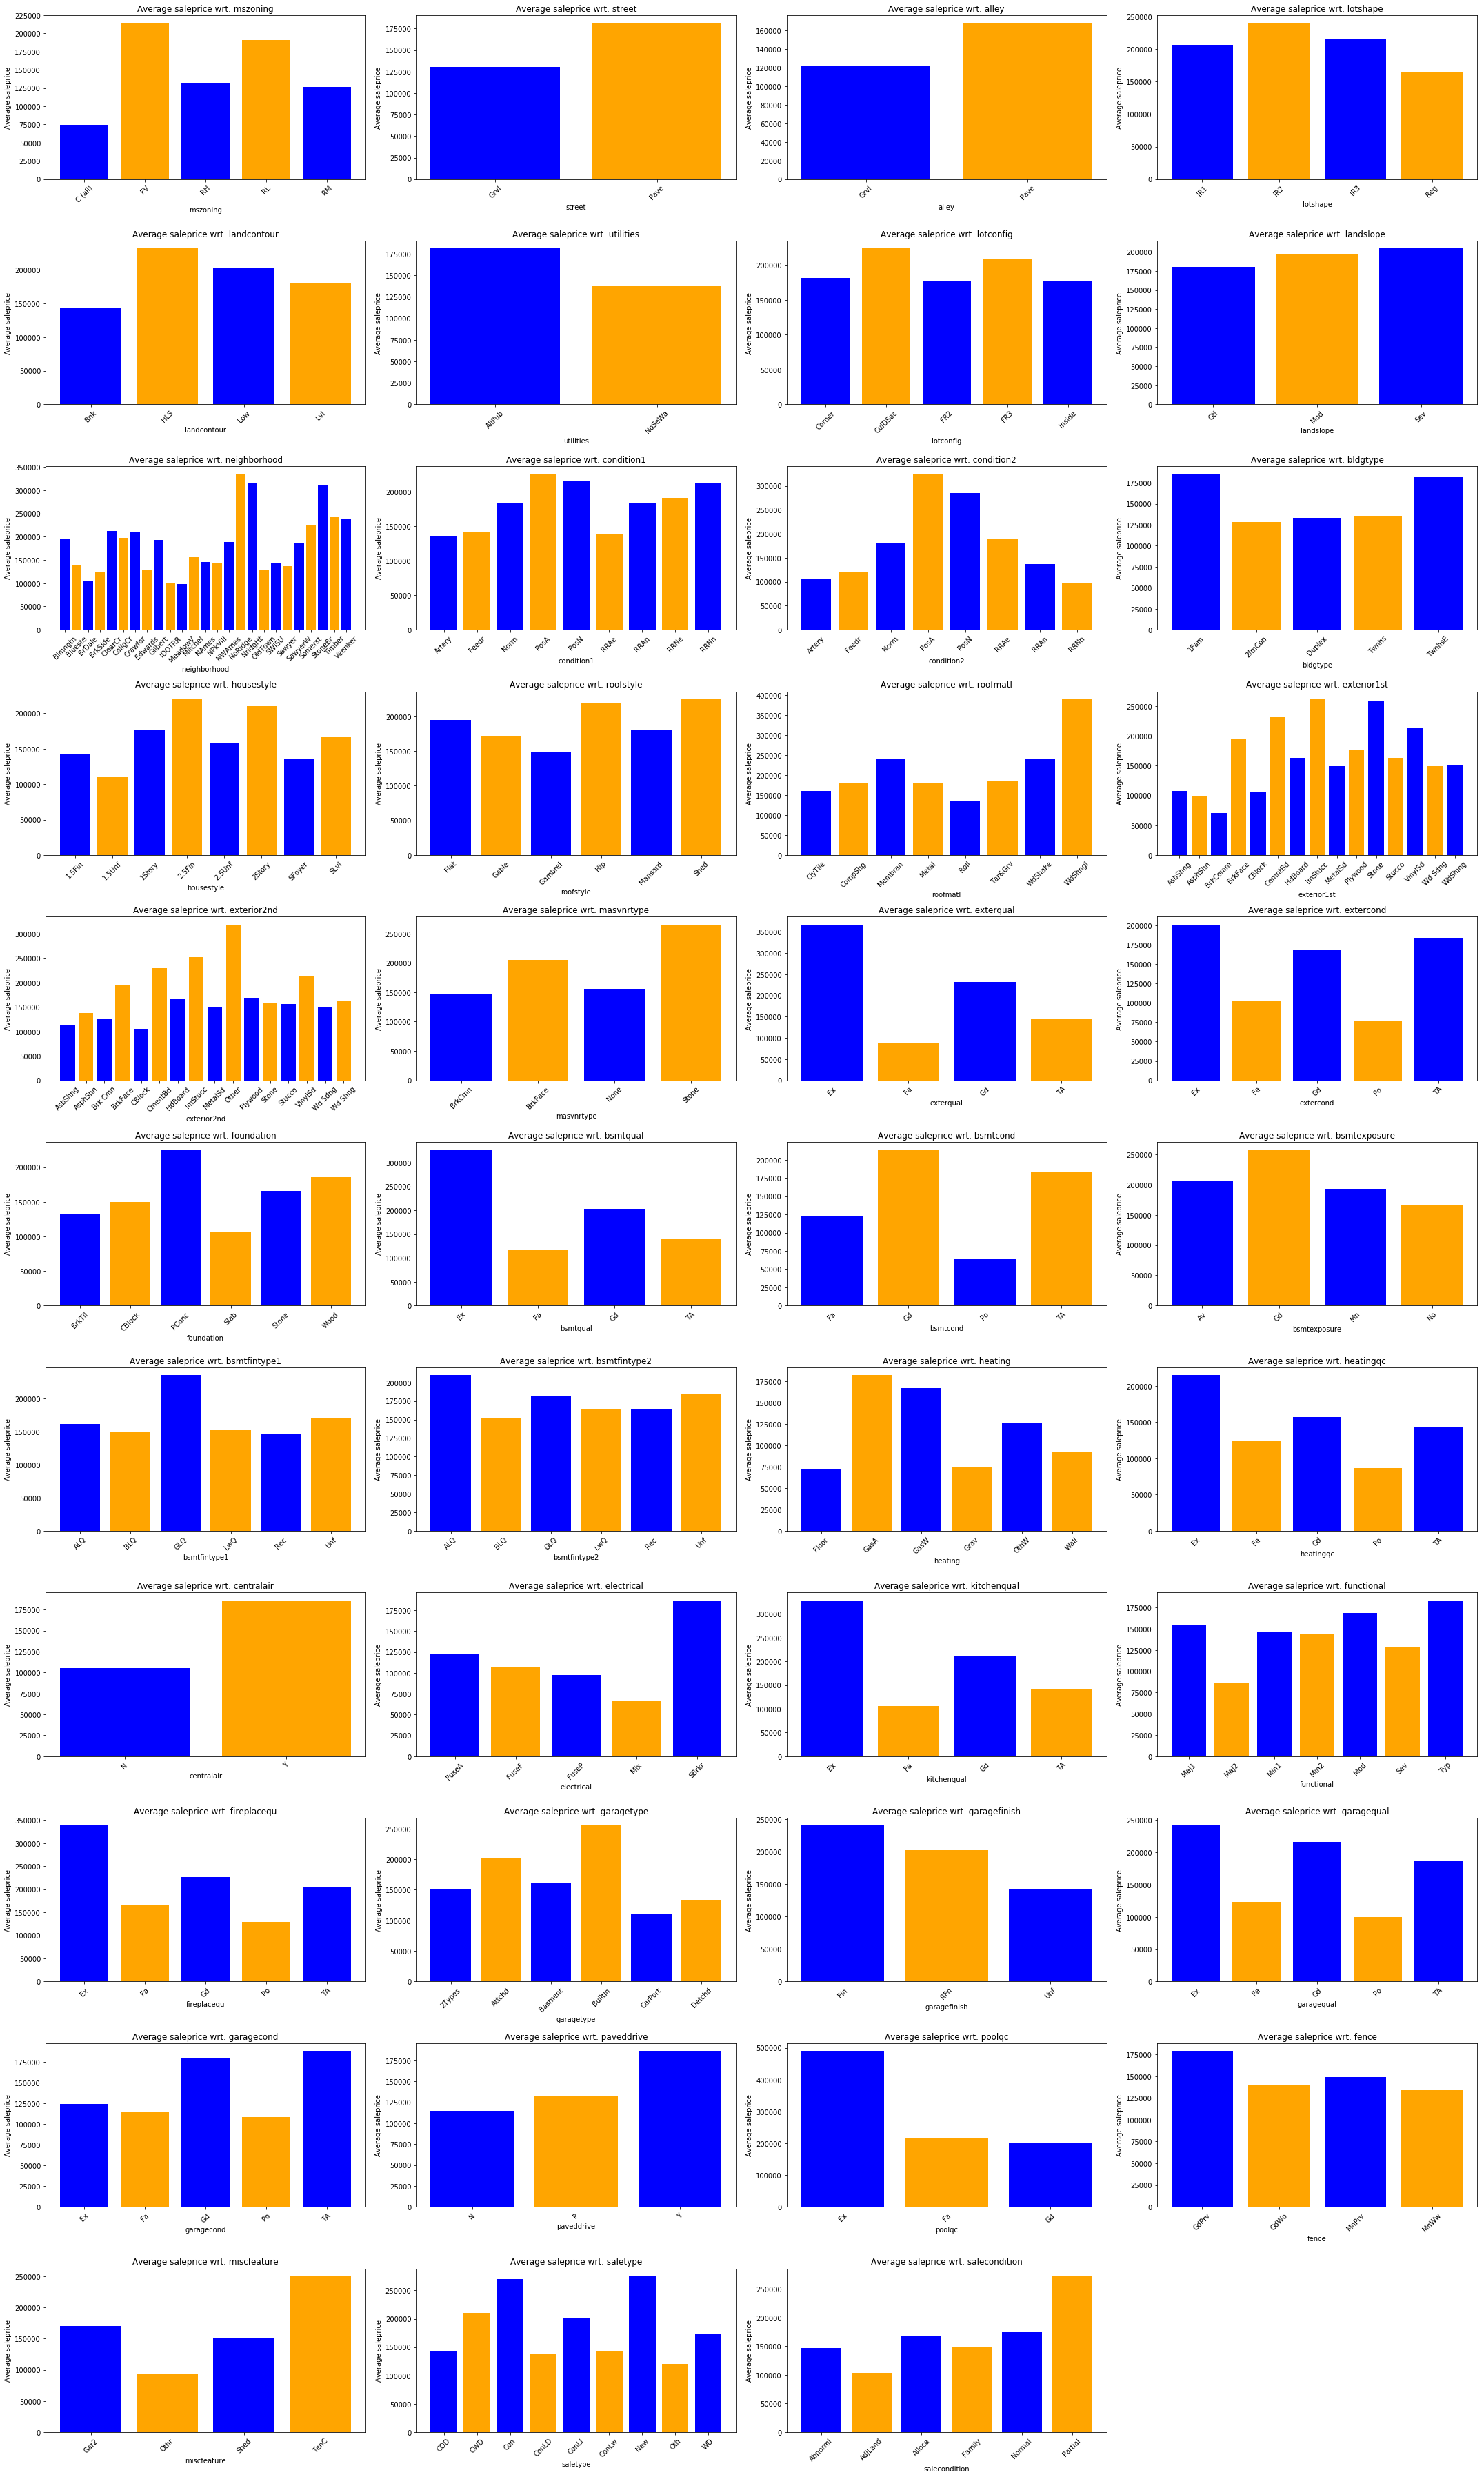

In [759]:
### Let's look at the categorical values with a bar plot and see what we can use. 

cat_cols = houseprices_df.select_dtypes(['object']).columns

plt.figure(figsize=(30,50))

for i, column in enumerate(cat_cols):
    plt.subplot(11,4,i+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index, houseprices_df.groupby(column)['saleprice'].mean(), color=['blue', 'orange'])
    plt.title('Average saleprice wrt. {}'.format(column))
    plt.ylabel('Average saleprice')
    plt.xlabel(column)
    plt.xticks(rotation='45')
plt.tight_layout()
plt.show()

In [760]:
houseprices_df1.head() #just to be sure, take a look at dummies

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


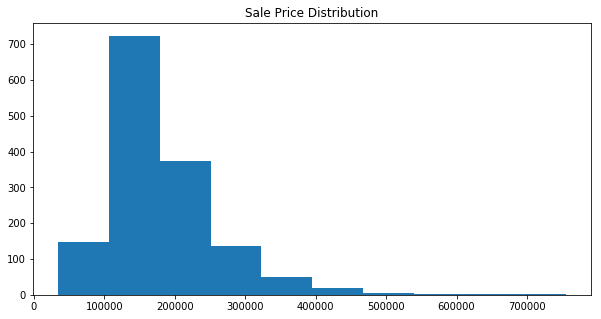

In [761]:
#Let's look at the saleprice distribution as well. 
plt.figure(figsize=(10,5))
plt.hist(houseprices_df1.saleprice)
plt.title('Sale Price Distribution')
plt.show()
#saleprice is skewed to the right. 

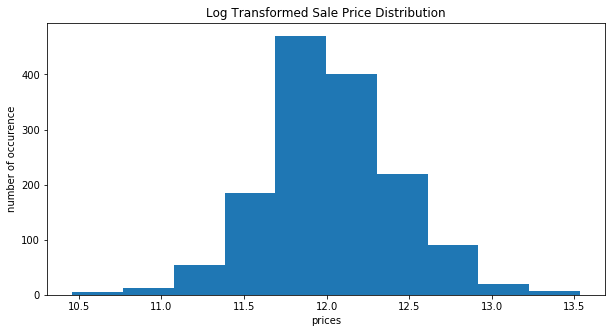

In [762]:
#I want to make my saleprice distribution normal. Let's call on np.log

houseprices_df1['log_sale_price'] = np.log1p(houseprices_df1.saleprice)


plt.figure(figsize=(10,5))

plt.hist(houseprices_df1.log_sale_price)
plt.title('Log Transformed Sale Price Distribution')
plt.xlabel('prices')
plt.ylabel('number of occurence')
plt.show()

# Now, split your data into train and test sets where 20% of the data resides in the test set.

In [763]:
#create a new data frame with selected features. I wanted to add bsmntfintype 2, but it needed some cleaning before
#dummy creation. 
houseprices_df2= houseprices_df1[['overallqual', 'grlivarea', 'garagecars', 
                                  'garagearea', 'totalbsmtsf', 'log_sale_price', 
                                  'lotarea', 'overallcond', 'bsmtfintype2', 'street']]

houseprices_df2['bsmtfintype2'] = houseprices_df2.bsmtfintype2.fillna('no_bsmnt')



In [764]:
houseprices_df2.bsmtfintype2.isnull().sum() # making sure there is no more null

0

In [765]:

houseprices_df2 = pd.concat([houseprices_df2,pd.get_dummies(houseprices_df2.bsmtfintype2, prefix="bsmtfintype2", drop_first=True)], axis=1)
houseprices_df2 = pd.concat([houseprices_df2,pd.get_dummies(houseprices_df2.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houseprices_df2.bsmtfintype2, prefix="bsmtfintype2", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df2.street, prefix="street", drop_first=True).columns)


In [766]:
X = houseprices_df2[['overallqual', 'grlivarea', 'garagecars', 
                    'garagearea', 'totalbsmtsf',
                    'lotarea', 'overallcond'] + dummy_column_names]


Y = houseprices_df2.log_sale_price

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


# Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!  Evaluate your best model on the test set.

### Linear regression model 1

In [767]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     338.9
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:41:07   Log-Likelihood:                 374.96
No. Observations:                1168   AIC:                            -719.9
Df Residuals:                    1153   BIC:                            -644.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.31

- Our R squared  and adj. R squared is about 80%. 
- We have an F statistic of 338.9 with a significant p value of less than 0.05. 
- Our AIC is -719.9 and BIC is -644.0
- When we look at our coefficients, overallqual, grlivarea, garagecars, totalbsmtsf, lotarea and overallcond are statistically significant.

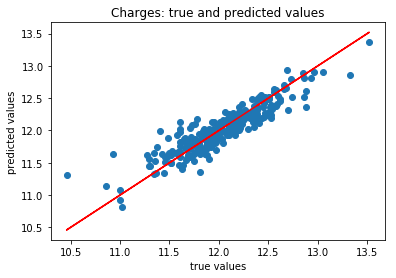

Mean absolute error of the prediction is: 0.12533303518036015
Mean squared error of the prediction is: 0.02945551371563975
Root mean squared error of the prediction is: 0.1716260869321437
Mean absolute percentage error of the prediction is: 1.0495685192298516


In [768]:
#Let's look at the plot and make predictions
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


- We can definitely do better with this mode. Let's try changing some features and see. 


### Model #2

In [769]:
#create a new dataframe with new features.

houseprices_df3= houseprices_df1[['log_sale_price', 'yrsold', 'overallqual', 'grlivarea',
                                  'garagecars', 'totalbsmtsf', 'lotarea', 'overallcond', 
                                  'lotconfig']]


In [770]:
#create new dummy columns. This time I will be using different features. Just thinking,if im a house buyer, I would 
#want some lot information. 
houseprices_df3 = pd.concat([houseprices_df3,pd.get_dummies(houseprices_df3.lotconfig, prefix="lotconfig", drop_first=True)], axis=1)
dummy_column_names2 = list(pd.get_dummies(houseprices_df3.lotconfig, prefix="lotconfig", drop_first=True).columns)


In [771]:
X = houseprices_df3[['overallqual', 'grlivarea', 'garagecars', 
                     'totalbsmtsf', 'lotarea', 'overallcond'] + dummy_column_names2]
                    
Y = houseprices_df3.log_sale_price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [772]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     484.3
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:41:08   Log-Likelihood:                 382.99
No. Observations:                1168   AIC:                            -744.0
Df Residuals:                    1157   BIC:                            -688.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.3521      0.03

- This is slightly better. The lotconfig_CulDSac is statistically significant. We will keep this feature and get rid of the other lot features. R squared and R adjusted squared are 80%. AIC and BIC -744.0 and -688.3. 
- F statistic is 484.3 and is still has significant pvalue. 

In [773]:
#Let's do more work and focus on what we can do with features. 

### Model 3

In [774]:
#This model, we got rid of lot features except statistically significant one (lotconfig_CulDSac). 
X = houseprices_df3[['overallqual', 'grlivarea', 'garagecars', 
                     'totalbsmtsf', 'lotarea', 'overallcond', 'lotconfig_CulDSac']]
                    
Y = houseprices_df3.log_sale_price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [775]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     691.3
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:41:08   Log-Likelihood:                 381.41
No. Observations:                1168   AIC:                            -746.8
Df Residuals:                    1160   BIC:                            -706.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.3695      0.03

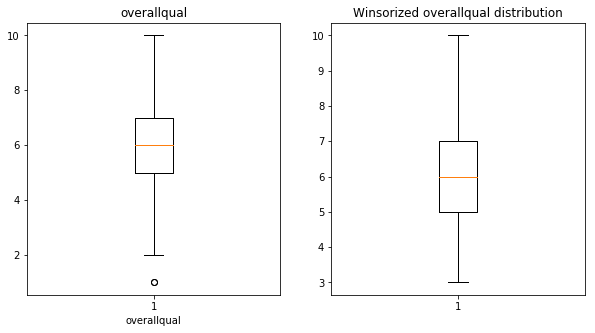

In [776]:
# Ok, what else can I do to improve it? Let me look at the distributions of the features and its outliers.

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot(houseprices_df3.overallqual)
plt.title('overallqual')
plt.xlabel('overallqual')

#Let's winsorize features then try our model again. 
houseprices_df3['win_overallqual'] = winsorize(houseprices_df3.overallqual, (0.01, 0))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df3.win_overallqual)
plt.title('Winsorized overallqual distribution')
plt.show()


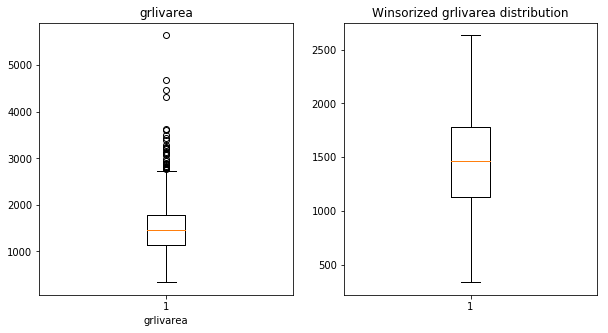

In [777]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df3.grlivarea)
plt.title('grlivarea')
plt.xlabel('grlivarea')


houseprices_df3['win_grlivarea'] = winsorize(houseprices_df3.grlivarea, (0,0.03))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df3.win_grlivarea)
plt.title('Winsorized grlivarea distribution')
plt.show()

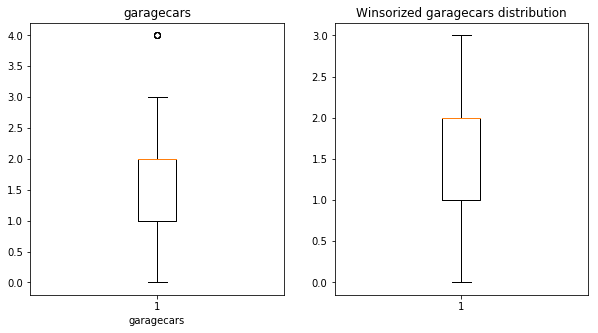

In [778]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df3.garagecars)
plt.title('garagecars')
plt.xlabel('garagecars')


houseprices_df3['win_garagecars'] = winsorize(houseprices_df3.garagecars, (0,0.1))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df3.win_garagecars)
plt.title('Winsorized garagecars distribution')
plt.show()

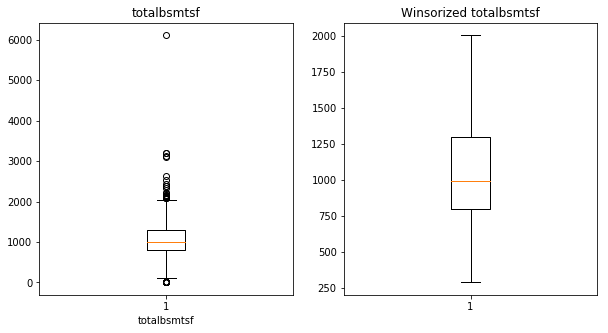

In [779]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df3.totalbsmtsf)
plt.title('totalbsmtsf')
plt.xlabel('totalbsmtsf')


houseprices_df3['win_totalbsmtsf'] = winsorize(houseprices_df3.totalbsmtsf, (0.03,.02))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df3.win_totalbsmtsf)
plt.title('Winsorized totalbsmtsf')
plt.show()

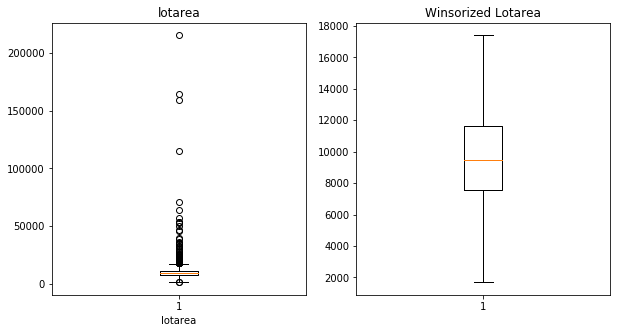

In [780]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df3.lotarea)
plt.title('lotarea')
plt.xlabel('lotarea')


houseprices_df3['win_lotarea'] = winsorize(houseprices_df3.lotarea, (0.01,0.05))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df3.win_lotarea)
plt.title('Winsorized Lotarea')
plt.show()

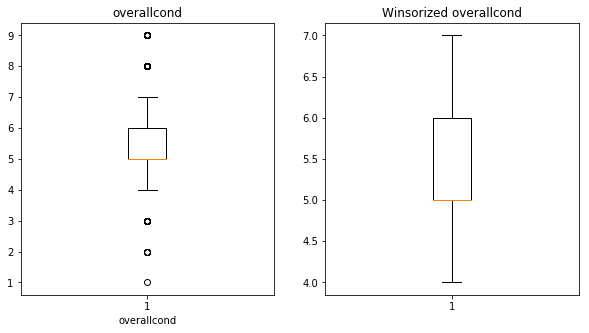

In [781]:

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(houseprices_df3.overallcond)
plt.title('overallcond')
plt.xlabel('overallcond')


houseprices_df3['win_overallcond'] = winsorize(houseprices_df3.overallcond, (0.03,0.07))
plt.subplot(1,2,2)
plt.boxplot(houseprices_df3.win_overallcond)
plt.title('Winsorized overallcond')
plt.show()

### Model 4

In [782]:
#Excited to try this one! 
X = houseprices_df3[['win_overallqual', 'win_grlivarea', 'win_garagecars', 
                     'win_totalbsmtsf', 'win_lotarea', 'win_overallcond', 'lotconfig_CulDSac']]
                    
Y = houseprices_df3.log_sale_price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [783]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     860.4
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:41:10   Log-Likelihood:                 486.58
No. Observations:                1168   AIC:                            -957.2
Df Residuals:                    1160   BIC:                            -916.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.1718      0.04

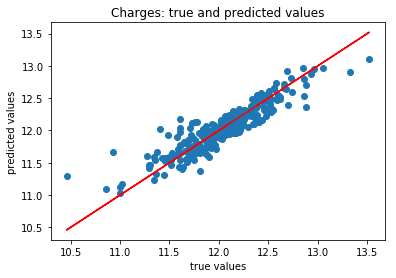

Mean absolute error of the prediction is: 0.12222713668001975
Mean squared error of the prediction is: 0.02807959036150867
Root mean squared error of the prediction is: 0.1675696582365336
Mean absolute percentage error of the prediction is: 1.0230548219608628


In [784]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


In [785]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))

R-squared of the model in the training set is: 0.838500871558354
-----Test set statistics-----
R-squared of the model in the test set is: 0.8316022603245591


- Our R adj squared increased from 0.805 to 0.838!
- There isn't much difference between our R squared from the train set and the test set which means we are not overfitting!
- MEA, MSE, RMSE, and MAPE are lowered as well from previous. 
- This model is the best one so far. 
- Now let's see if it will be better to have other models such as lasso, ridge and elasticnet.

### Ridge with CV

In [786]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

alphas = [np.power(10.0,p) for p in np.arange(-10,50,1)]
# I chose 10 k folds. 
ridge_cv = RidgeCV(alphas=alphas, cv=10)

ridge_cv.fit(X_train, y_train)

y_train_preds = ridge_cv.predict(X_train)
y_test_preds = ridge_cv.predict(X_test)

print('Best alpha value is {}'.format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 1.0
R-squared of the model in training set is: 0.8385003707110426
-----Test set statistics-----
R-squared of the model in test set is: 0.8316058805841413
Mean absolute error of the prediction is: 0.12222410452009862
Mean squared error of the prediction is: 0.02807898669894748
Root mean squared error of the prediction is: 0.16756785699813517
Mean absolute percentage error of the prediction is: 1.0230409985192292


### Lasso with CV

In [787]:

lasso_cv = LassoCV(alphas=alphas, cv=10)
lasso_cv.fit(X_train, y_train)

y_train_preds = lasso_cv.predict(X_train)
y_test_preds = lasso_cv.predict(X_test)

print('Best alpha value is {}'.format(lasso_cv.alpha_))
print('R-squared of the model on the training set is: {}'.format(lasso_cv.score(X_train, y_train)))
print('---------Test set statistic--------------')
print('R-squared of the model on the test set is: {}'.format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 1e-10
R-squared of the model on the training set is: 0.838500871558354
---------Test set statistic--------------
R-squared of the model on the test set is: 0.8316022603360675
Mean absolute error of the prediction is: 0.12222713666498043
Mean squared error of the prediction is: 0.02807959035956142
Root mean squared error of the prediction is: 0.1675696582307233
Mean absolute percentage error of the prediction is: 1.023054821855631


### ElasticNet with CV

In [788]:

elastic_cv = ElasticNetCV(alphas=alphas, cv=10)
elastic_cv.fit(X_train, y_train)

# making prediction
y_train_preds = elastic_cv.predict(X_train)
y_test_preds = elastic_cv.predict(X_test)

print('Best alpha value is {}'.format(elastic_cv.alpha_))
print("R-squared of the model on the training set is: {}".format(elastic_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elastic_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 1e-10
R-squared of the model on the training set is: 0.838500871558354
-----Test set statistics-----
R-squared of the model on the test set is: 0.8316022603305568
Mean absolute error of the prediction is: 0.12222713667212345
Mean squared error of the prediction is: 0.028079590360480303
Root mean squared error of the prediction is: 0.16756965823346512
Mean absolute percentage error of the prediction is: 1.0230548219057882


- After comparing all of our models, I believe model 4 is the best one.

# So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

Keeping in mind other factors that could affect house prices, I've decided to look at some factors such as the economic growth, unemployment rate, interest rates, supply of houses etc. I will use GDP growth rate and interest rates as my outside factor.

In [789]:
#looking at yr sold values
houseprices_df1.yrsold.unique()

array([2008, 2007, 2006, 2009, 2010])

In [790]:
#df1 = pd.DataFrame({'Int_rate':[6.15, 6.22, 5.76, 5.05, 5.03],
#                    'gdp_growth_rate':[2.59, 1.97, -2.75, 0.18, 2.57], 
#                        'yrsold':[2006, 2007, 2008, 2009, 2010]})


In [791]:
int_rate = pd.DataFrame([6.15, 6.22, 5.76, 5.05, 5.03], columns=['int_rate'])
int_rate['yrsold'] = [2006, 2007, 2008, 2009, 2010]
int_rate

,int_rate,yrsold
0,6.15,2006
1,6.22,2007
2,5.76,2008
3,5.05,2009
4,5.03,2010


In [792]:
gdp_growth_rate = pd.DataFrame([2.59, 1.97, -2.75, 0.18, 2.57], columns=['gdp_growth_rate'])
gdp_growth_rate['yrsold'] = [2006, 2007, 2008, 2009, 2010]
gdp_growth_rate

,gdp_growth_rate,yrsold
0,2.59,2006
1,1.97,2007
2,-2.75,2008
3,0.18,2009
4,2.57,2010


In [793]:
#adding int_rate and gdp to df
houseprices_df3['int_rate'] = houseprices_df3['yrsold'].map(int_rate.set_index('yrsold')['int_rate'])
houseprices_df3['gdp_growth_rate'] = houseprices_df3['yrsold'].map(gdp_growth_rate.set_index('yrsold')['gdp_growth_rate'])


In [794]:
houseprices_df3.head()

,log_sale_price,yrsold,overallqual,grlivarea,garagecars,totalbsmtsf,lotarea,overallcond,lotconfig,lotconfig_CulDSac,...,lotconfig_FR3,lotconfig_Inside,win_overallqual,win_grlivarea,win_garagecars,win_totalbsmtsf,win_lotarea,win_overallcond,int_rate,gdp_growth_rate
0,12.247699,2008,7,1710,2,856,8450,5,Inside,0,...,0,1,7,1710,2,856,8450,5,5.76,-2.75
1,12.109016,2007,6,1262,2,1262,9600,8,FR2,0,...,0,0,6,1262,2,1262,9600,7,6.22,1.97
2,12.317171,2008,7,1786,2,920,11250,5,Inside,0,...,0,1,7,1786,2,920,11250,5,5.76,-2.75
3,11.849405,2006,7,1717,3,756,9550,5,Corner,0,...,0,0,7,1717,3,756,9550,5,6.15,2.59
4,12.429220,2008,8,2198,3,1145,14260,5,FR2,0,...,0,0,8,2198,3,1145,14260,5,5.76,-2.75


In [795]:
houseprices_df3 = pd.concat([houseprices_df3,pd.get_dummies(houseprices_df3.yrsold, prefix="yrsold", drop_first=True)], axis=1)
dummy_column_names2 = list(pd.get_dummies(houseprices_df3.yrsold, prefix="yrsold", drop_first=True).columns)
houseprices_df3 = pd.concat([houseprices_df3,pd.get_dummies(houseprices_df3.int_rate, prefix="int_rate", drop_first=True)], axis=1)
dummy_column_names2 = dummy_column_names2 + list(pd.get_dummies(houseprices_df3.int_rate, prefix="int_rate", drop_first=True).columns)
houseprices_df3 = pd.concat([houseprices_df3,pd.get_dummies(houseprices_df3.gdp_growth_rate, prefix="gdp_growth_rate", drop_first=True)], axis=1)
dummy_column_names2 = dummy_column_names2 + list(pd.get_dummies(houseprices_df3.gdp_growth_rate, prefix="gdp_growth_rate", drop_first=True).columns)


In [796]:
#created an interaction between int_rate and gdp
houseprices_df3['interaction']= houseprices_df3.int_rate * houseprices_df3.gdp_growth_rate

X = houseprices_df3[['win_overallqual', 'win_grlivarea', 'win_garagecars', 
                     'win_totalbsmtsf', 'win_lotarea', 'win_overallcond', 'lotconfig_CulDSac', 'interaction']
                   + dummy_column_names2]
                    
Y = houseprices_df3.log_sale_price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [797]:
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         log_sale_price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     546.3
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:41:15   Log-Likelihood:                 487.17
No. Observations:                1168   AIC:                            -950.3
Df Residuals:                    1156   BIC:                            -889.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.6183 

In [712]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# making predictions
y_train_preds = lrm.predict(X_train)
y_test_preds = lrm.predict(X_test)

print('R-squared of the model in the training set is: {}'.format(lrm.score(X_train, y_train)))
print('--------Test set statistics------------')
print('R-squared of the model in the test set is: {}'.format(lrm.score(X_test, y_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_test_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_test_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_test_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_test_preds)/y_test))*100))

R-squared of the model in the training set is: 0.8386648695012324
--------Test set statistics------------
R-squared of the model in the test set is: 0.8313221250924323
Mean absolute error of the prediction is: 0.12266930411796438
Mean squared error of the prediction is: 0.028126301692517865
Root mean squared error of the prediction is: 0.16770897916485528
Mean absolute percentage error of the prediction is: 1.0266553106388865


- It looks like our R squared has changed just a little bit in this model 4 to 0.839, model had 0.838
- The differences between R squared our train set and test set for this model very little, 0.007. But same can be said for model 4 which has 0.0069 difference. Both model shows that we do not have overfitting. 
- Very little difference is seen in MEA, MSE, RMSE, and MAPE values when compared to model 4. 
- All of our features are statistically significant. Initially I made the mistake of not dumming the variables int_rate and gdp_growth_rate. After using dummy variables, they became statistically significant. 
- I can conclude that this model is better than model 4. 

In [ ]:
#Reference for interest rates: https://www.multpl.com/us-real-gdp-growth-rate/table/by-year
#Reference for gdp_growth_rate: https://tradingeconomics.com/united-states/gdp-growth